# Image2Emoji Demo

- This notebook contains the demo for Image2Emoji, a Zero-shot Emoji Prediction model.  
- The model is based on OpenAI's CLIP model and is fine-tuned on Flickr-8k Dataset.  
- The model is able to predict the most relevant emoji for a given image.

## 📦 Installation
To install the required packages, run the following command:
```bash
pip install -r requirements.txt
```

In [1]:
#!pip install -r requirements.txt

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pytorch_lightning as pl
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import numpy as np

from src import lightning_model
from src.data import get_dataloaders

# Fix seed
pl.seed_everything(0, workers=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/root/anaconda3/envs/clip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


## 📚 Dataset

In [3]:
if not os.path.exists('Flickr8k'):
    print('Downloading the Flickr-8k dataset from Kaggle...')
    #os.system('wget

train_loader, val_loader = get_dataloaders(data_dir='Flickr8k', tokenizer_name='albert-base-v2', batch_size=16, num_workers=2)

## 📎 Model

In [4]:
model = lightning_model.CLIPModel(image_encoder_alias='resnet18', text_encoder_alias='albert-base-v2')
#model.load_state_dict(torch.load('model_weights/model.pth'))
#model.load_from_checkpoint('lightning_logs/version_0/checkpoints/epoch=0-step=0.ckpt')

## 🏃 Training

If you don't want to train the model, you can skip this section and directly jump to loading the trained model.

In [5]:
trainer = pl.Trainer(max_epochs=10, enable_checkpointing=False, callbacks=[lightning_model.OverrideEpochStepCallback(), EarlyStopping(monitor='val/loss', patience=30, verbose=False)])
trainer.fit(model, train_loader, val_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name             | Type           | Params
----------------------------------------------------
0 | image_encoder    | ImageEncoder   | 11.2 M
1 | text_

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


/root/anaconda3/envs/clip/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/root/anaconda3/envs/clip/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: You called `self.log('step', ...)` in your `on_validation_epoch_end` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'step': ...})` instead.


Epoch 0: 100%|██████████| 2023/2023 [04:03<00:00,  8.31it/s, v_num=1, train/loss_step=1.960]

/root/anaconda3/envs/clip/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 12. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1:   0%|          | 0/2023 [00:00<?, ?it/s, v_num=1, train/loss_step=1.960, val/loss_step=2.030, val/loss_epoch=2.270, train/loss_epoch=2.560]           

/root/anaconda3/envs/clip/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 11. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/root/anaconda3/envs/clip/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: You called `self.log('step', ...)` in your `on_train_epoch_end` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'step': ...})` instead.


Epoch 8:  36%|███▌      | 724/2023 [01:26<02:35,  8.34it/s, v_num=1, train/loss_step=2.100, val/loss_step=1.720, val/loss_epoch=2.090, train/loss_epoch=2.060] 

You can monitor the training process by tensorboard, run the following command:
```bash
tensorboard --logdir=logs
```


In [ ]:
%load_ext tensorboard
%tensorboard  --logdir lightning_logs/

In [ ]:
#torch.save(model.state_dict(), 'model_weights/model_epoch10.pth')

## 🤔 Inference

you can load the trained model and ensure that the model is able to predict which images correspond to which text descriptions.

In [ ]:
#model.load_state_dict(torch.load('model_weights/model.epoch10.pth'))
model.eval()

CLIPModel(
  (image_encoder): ImageEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (co

In [ ]:
images, texts, captions = next(iter(val_loader))

### cosine similarity matrix between images and text descriptions

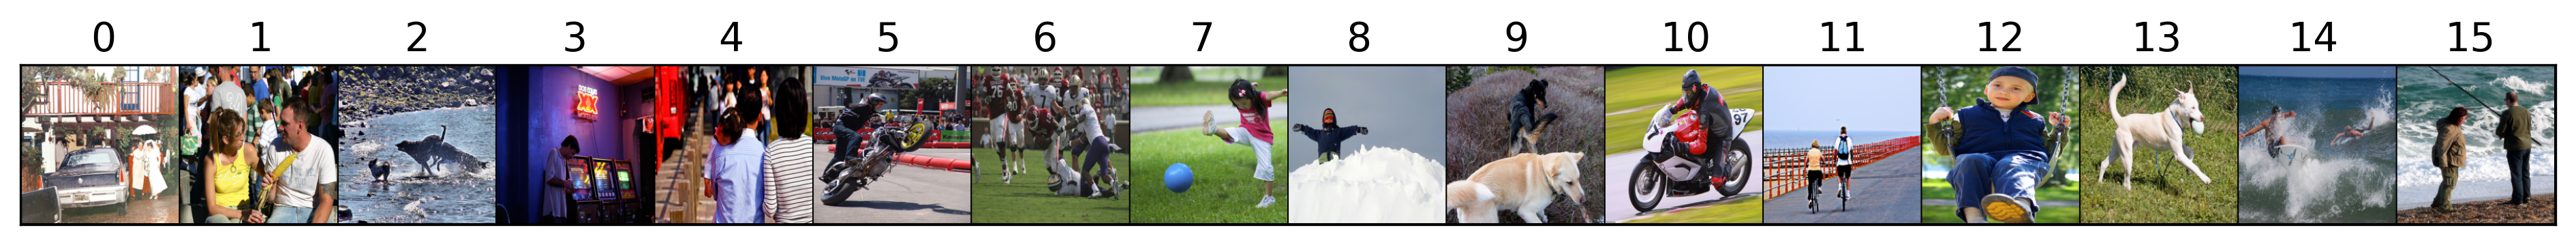

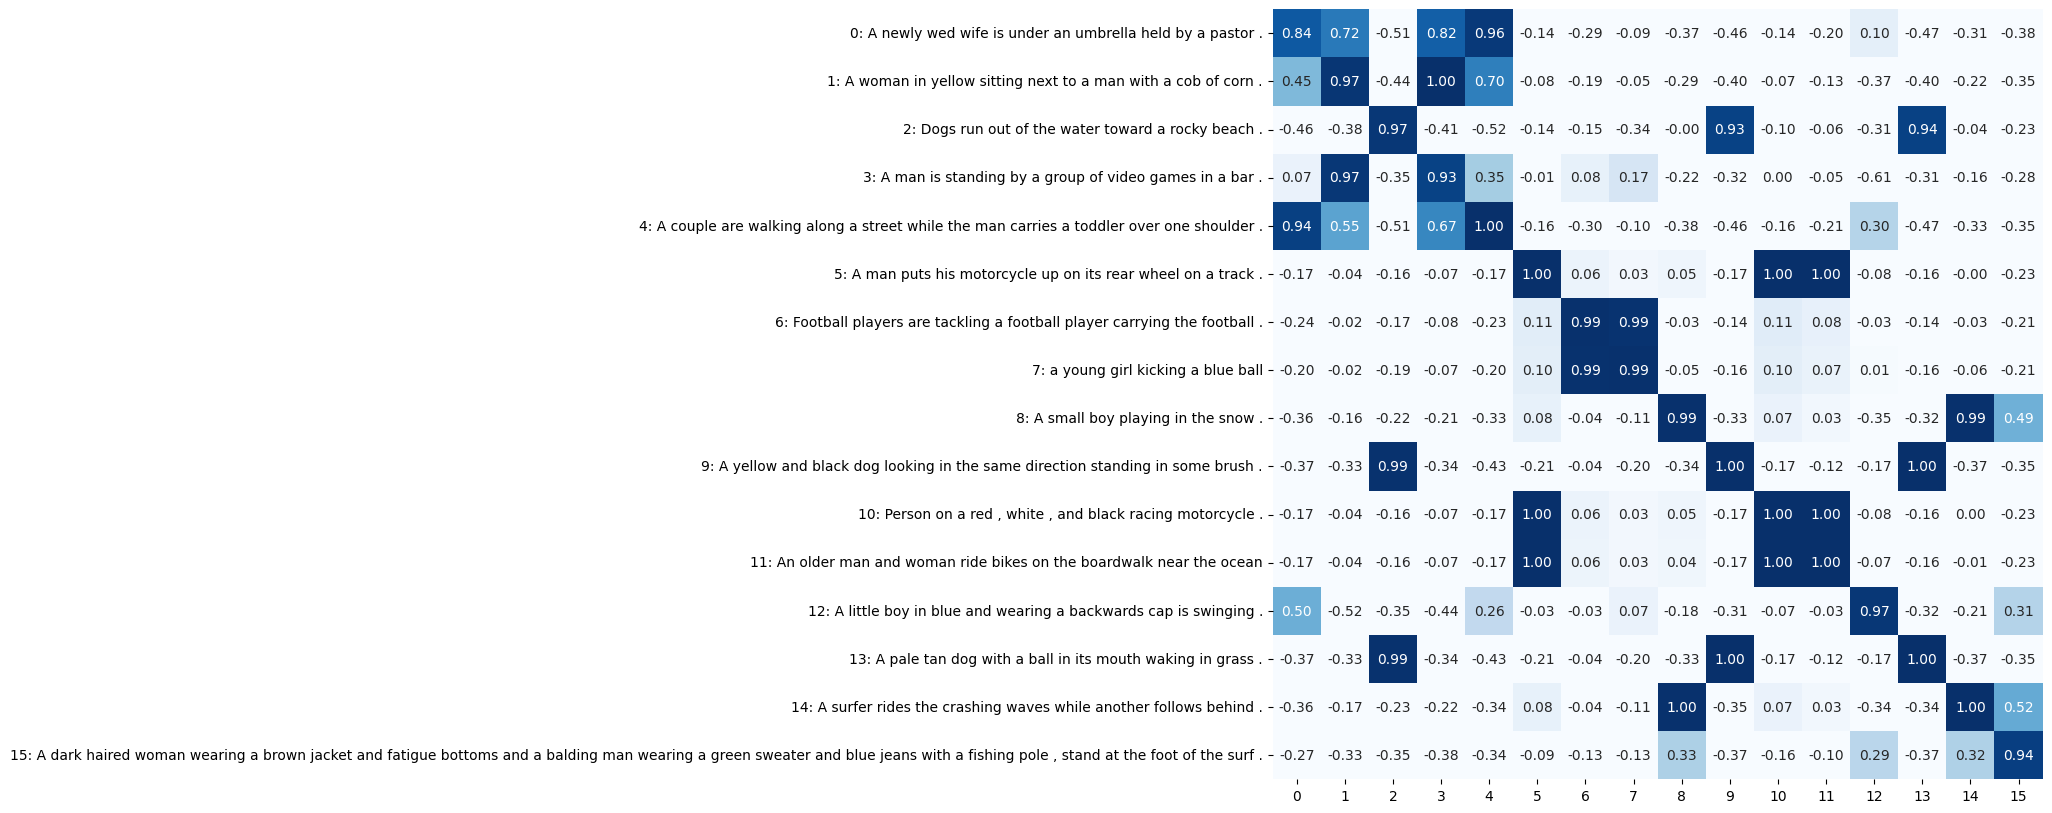

In [ ]:
# show images
row_images = images / 2 + 0.5
fig, ax = plt.subplots(figsize=(16, 16), dpi=300)
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(row_images.detach()[:row_images.size(0)], nrow=16).permute(1, 2, 0))
for i in range(row_images.size(0)):
    ax.text(i%16*224+100, i//16*224-20, str(i), fontsize=14, color='black')
plt.show()

# show captions and similarity matrix
plt.figure(figsize=(10,10))
model.eval()
image_embeddings, text_embeddings = model((images, texts))
similarity = (text_embeddings @ image_embeddings.T)
sns.heatmap(similarity.detach().cpu().numpy(), vmin=0, vmax=1, cmap="Blues", annot=True, square=True, fmt=".2f", cbar=False)
plt.yticks(ticks=np.arange(len(captions))+0.5, labels=[f'{i}: {caption}' for i, caption in enumerate(captions)], rotation=0)
plt.show()

## 📝 Refferences
- [CLIP Paper](https://arxiv.org/abs/2103.00020)
- [CLIP wandb Implementation](https://github.com/soumik12345/clip-lightning)
- [Flickr-8k Dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k)
- [Emoji Dataset](https://huggingface.co/datasets/valhalla/emoji-dataset)